In [1]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F



In [2]:
# ✅ Load Pretrained Keypoint R-CNN model
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set to evaluation mode

# ✅ Move model to CPU
device = torch.device("cpu")
model.to(device)


c:\Users\Habeeba\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Habeeba\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [3]:
def draw_keypoints(image, keypoints):
    """Draws keypoints on the image."""
    for x, y, conf in keypoints:  # Keypoints contain (x, y, confidence)
        if conf > 0.5:  # Draw only if confidence is high
            cv2.circle(image, (int(x), int(y)), 5, (255, 0, 0), -1)
    return image

def load_image(image_path):
    """Loads an image, converts it to a PyTorch tensor."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
    return image, image_tensor


In [4]:
# Define keypoints indexes for COCO dataset
COCO_KEYPOINTS = {
    "LEFT_SHOULDER": 5,
    "LEFT_ELBOW": 7,
    "LEFT_WRIST": 9,
    "LEFT_HIP": 11,
    "LEFT_KNEE": 13,
    "LEFT_ANKLE": 15,
}

def predict_keypoints(model, image_tensor, image_shape, threshold=0.5):
    """Runs Keypoint R-CNN model and returns selected keypoints."""
    with torch.no_grad():
        outputs = model(image_tensor)

    keypoints = outputs[0]["keypoints"].cpu().numpy()
    scores = outputs[0]["scores"].cpu().numpy()

    # Keep only keypoints with confidence above threshold
    keypoints = keypoints[scores > threshold]

    if keypoints.shape[0] == 0:
        return None

    height, width = image_shape[:2]
    selected_keypoints = {}

    for name, index in COCO_KEYPOINTS.items():
        x, y, conf = keypoints[0][index]  # Extract the keypoint
        x_normalized = x / width  # Normalize x
        y_normalized = y / height  # Normalize y
        selected_keypoints[name] = (x_normalized, y_normalized, conf)

    return selected_keypoints


Normalized Keypoints (0-1 range) with Confidence Scores:
LEFT_SHOULDER: (x=0.50577, y=0.21332, confidence=1.00)
LEFT_ELBOW: (x=0.47061, y=0.28806, confidence=1.00)
LEFT_WRIST: (x=0.42349, y=0.36412, confidence=1.00)
LEFT_HIP: (x=0.56112, y=0.36813, confidence=1.00)
LEFT_KNEE: (x=0.48857, y=0.45887, confidence=1.00)
LEFT_ANKLE: (x=0.50801, y=0.62168, confidence=1.00)


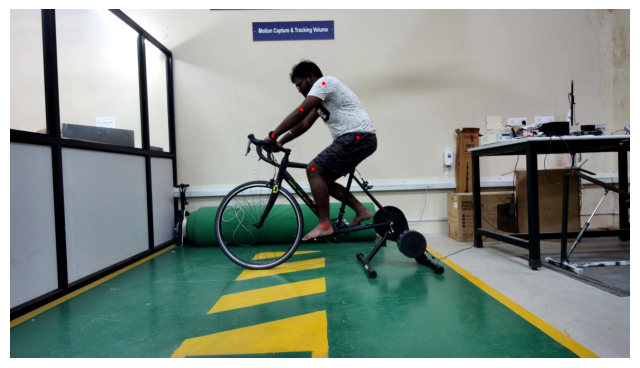

In [6]:
# Provide your image path (Update if needed)
image_path = r"C:\PJT2\Orbbec_Dataset_New\Orbbec_Dataset\Dataset\CHECK DATASET\checkdataset\6.png" # Replace with your image file

# Load and process image
image, image_tensor = load_image(image_path)

# Predict keypoints
keypoints = predict_keypoints(model, image_tensor, image.shape)

# Print and visualize keypoints
if keypoints:
    print("Normalized Keypoints (0-1 range) with Confidence Scores:")
    for name, (x_norm, y_norm, conf) in keypoints.items():
        print(f"{name}: (x={x_norm:.5f}, y={y_norm:.5f}, confidence={conf:.2f})")

    # Draw the selected keypoints on the image
    output_image = draw_keypoints(image.copy(), [(x * image.shape[1], y * image.shape[0], conf) for x, y, conf in keypoints.values()])

    # Display the image inline in Colab
    plt.figure(figsize=(8, 8))
    plt.imshow(output_image)
    plt.axis("off")
    plt.show()
else:
    print("No valid keypoints detected.")
